In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
tf.__version__

'2.0.0'

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, 'Not enough GPU hardware devices available'
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import *
from tensorflow.keras import activations

In [4]:
BATCH_SIZE = 8 
EPOCHS = 100
NUMIMAGES = 1000
BUFFER_SIZE = 20

In [5]:
lambda_cls = 0.5
lambda_flow = 0.1
lambda_mask = 0.1
lambda_landmark = 10
lambda_reco = 5

In [5]:
from SectionImageLoad import *

In [6]:
from AutoEncoderModel import *
from STNFunction import *
from GeoGAN_losses import *
from coco2017_load import resize_skeleton_image

In [8]:
# Preprocessing CelebA images
IMG_SIZE = (128,128,3)
Ax_filenames_ds,By_filenames_ds,landmark_dict = load_csvdata_weneed()
(Ax,Ax_landmark),(By,By_landmark) = get_raw_image(Ax_filenames_ds,By_filenames_ds,landmark_dict)
Ax = Ax[:NUMIMAGES]
Ax_landmark = Ax_landmark[:NUMIMAGES]
By = By[:NUMIMAGES]
By_landmark = By_landmark[:NUMIMAGES]
Ax_ds = tf.data.Dataset.from_tensor_slices((Ax, Ax_landmark))
Ax_ds = Ax_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
By_ds = tf.data.Dataset.from_tensor_slices((By, By_landmark))
By_ds = By_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def img_to_float(img):
    return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
    return np.uint8(img*127.5+128).clip(0, 255)

In [8]:
IMG_SIZE = (128,64,3)
# def tf_resize_skeleton_image(img,landmarks,newsize):
#     [image,landmark] = tf.py_function(resize_skeleton_image, [img,landmarks,newsize], [tf.float32])
#     return image,landmark
import json
def load_coco2017_data(data_path):
    imgs = None
    skes = None
    with open(data_path) as json_file:
        data = json.load(json_file)
        for one in data:
            img = cv2.imread("./Dataset/coco2017/skeleton_train2017/"+one['skeleton_id'],cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            landmark = one['keypoints']
            img,landmark = resize_skeleton_image(img,landmark,IMG_SIZE)
            img = img_to_float(img)
            landmark = np.reshape(landmark,(17,2))
            X = (landmark[:,0]-32)/32
            Y = (landmark[:,1]-127.5)/127.5
            
            landmark = np.stack([X,Y],1)
            if imgs is None:
                imgs = np.array([img])
                skes = np.array([landmark])
            else:
                imgs = np.append(imgs,[img],axis=0)
                skes = np.append(skes,[landmark],axis=0)
    return imgs, skes
COCO_SKEDATA_PATH = "./Dataset/coco2017/annotations/skeleton_train2017_related.json"
data_imgs, data_skes = load_coco2017_data(COCO_SKEDATA_PATH)

In [25]:
data_skes[0]

array([[ 0.05714286, -0.87933635],
       [ 0.14285714, -0.91312217],
       [-0.08571429, -0.90346908],
       [ 0.4       , -0.90346908],
       [-0.17142857, -0.88898944],
       [ 0.62857143, -0.78763198],
       [-0.48571429, -0.78763198],
       [ 0.8       , -0.66696833],
       [-0.77142857, -0.65731523],
       [ 0.74285714, -0.59457014],
       [-0.71428571, -0.57526395],
       [ 0.31428571, -0.53665158],
       [-0.37142857, -0.54147813],
       [ 0.45714286, -0.29532428],
       [-0.57142857, -0.44494721],
       [ 0.37142857, -0.08295626],
       [-0.4       , -0.28567119]])

In [9]:
Ax_ds = tf.data.Dataset.from_tensor_slices((data_imgs[:2016], data_skes[:2016]))
Ax_ds = Ax_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
By_ds = tf.data.Dataset.from_tensor_slices((data_imgs[2016:4033], data_skes[2016:4033]))
By_ds = By_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def draw_landmark_face(raw_img,raw_landmark):
    img = np.clip((raw_img+1)/2,0,1)
    # X = raw_landmark[:,0]
    # Y = raw_landmark[:,1]
    X = np.clip((raw_landmark[:,0]*32+32),0,64)
    Y = np.clip((raw_landmark[:,1]*127.5)+128,0,128)
    implot = plt.imshow(img)
    plt.scatter(X,Y,c='r',s=5)
    plt.show()

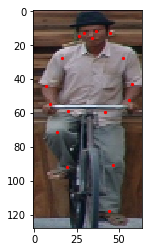

In [27]:
draw_landmark_face(data_imgs[0],data_skes[0])

In [11]:
class generator_model(Model):
    def __init__(self, img_size, batch_size, num_filter=32):
        super(generator_model, self).__init__()
        self.flowNet = autoencoder_model(num_filter,2,img_size,"channels_last","flowNet")
        self.grid_np = np.float32(np.mgrid[-1:1 + 1e-7 :2 / (img_size[0] - 1), -1:1 + 1e-7:2 / (img_size[1] - 1)])
        self.grid_np = np.moveaxis(self.grid_np, [-2,-1], [0, 1])
        self.flow_grid_np = tf.convert_to_tensor(\
                                tf.constant(np.stack([self.grid_np]*batch_size)),
                                                dtype=tf.float32)
        self.test_grid_np = tf.convert_to_tensor(tf.constant(self.grid_np), dtype=tf.float32)
        
        self.maskNet = autoencoder_model(num_filter,1,img_size,"channels_last","maskNet")
        self.refinementNet = autoencoder_model(num_filter,3,img_size,"channels_last","RefinementNet")
        # ------------
        self.removeResidualNet = autoencoder_model(num_filter,3,img_size,"channels_last","RemovalNet")
        
        self.removeconcat = Concatenate(axis=3)
        self.flowconcat = Concatenate(axis=3)
        self.maskconcat = Concatenate(axis=3)
        self.refineconcat = Concatenate(axis=3)
    def call(self, Ax, By, epoch, training=True):
        # Ax_flow is zeros
        fake_Ay, By_flow, raw_By_mask, By_warpped, By_mask, raw_fake_Ay, residual_Ay = self.addAttribute(Ax,By,epoch,training)
        fake_Bx = self.removeAttribute(By,raw_By_mask,training)
        
        # fakeBx_flow is zeros
        # (Testing)fake_Ay -> raw_Ay
        fakeBx_to_By, fakeAy_flow, raw_fakeAx_mask, _, _, raw_fakeBx_to_By, _ = \
                    self.addAttribute(fake_Bx,fake_Ay,epoch,training)
        fakeAy_to_Ax = self.removeAttribute(fake_Ay,raw_fakeAx_mask,training)
        
        return_items = {}
        return_items['fake_Ay'] = fake_Ay
        return_items['fakeAy_to_Ax'] = fakeAy_to_Ax
        return_items['fakeBx_to_By'] = fakeBx_to_By
        return_items['fake_Bx'] = fake_Bx
        return_items['flows'] = [By_flow, fakeAy_flow]
        return_items['masks'] = [raw_By_mask, raw_fakeAx_mask, By_mask]
        return_items['raw_fake_Ay'] = raw_fake_Ay
        return_items['By_warpped'] = By_warpped
        return_items['residual_Ay'] = residual_Ay
        
        return return_items
    # ----------------------------------------------------------
    def addAttribute(self,Ax,By,epoch,training):
        Ax_flow_front, By_flow_front, By_flow, By_warpped = self.callflowNet(Ax,By)
        raw_Ay, By_mask = self.callmaskNet(Ax,By_warpped)
        # make mask not to be warpped aka. converting to original one
        return_By_mask = self.warp_flow(By_mask,-By_flow, training)
        Ay, residual_Ay = self.callrefineNet(raw_Ay, By_mask, epoch)
        return Ay, By_flow, return_By_mask, By_warpped, By_mask, raw_Ay, residual_Ay
    
    def removeAttribute(self,By,mask,training):
        # mask_input = tf.stop_gradient(mask)
        # rBy = self.removeResidualNet(self.removeconcat([By,mask_input]))
        rBy = self.removeResidualNet(By)
        Bx = tf.clip_by_value(By + tf.keras.activations.tanh(rBy) * (1-mask),-1,1)
        # Bx = tf.clip_by_value(By + tf.keras.activations.tanh(rBy),-1,1)
        return Bx
    # ----------------------------------------------------------
    def callflowNet(self, Ax, By, training=True):
        Ax_front = self.flowNet.Encoder(Ax)
        By_front = self.flowNet.Encoder(By)
        fusion_BottleNeck = self.flowconcat([Ax_front, By_front])
        By_flow = self.flowNet.Decoder(fusion_BottleNeck)
        By_warpped = self.warp_flow(By, By_flow, training)
        return Ax_front, By_front, By_flow, By_warpped
    
    def callmaskNet(self,Ax,By_warpped,training=True):
        # maskNet
        Ax_front = self.maskNet.Encoder(Ax)
        By_warpped_front = self.maskNet.Encoder(By_warpped)
        # Blend
        bottleneck_fusion = self.maskconcat([Ax_front,By_warpped_front])
        By_mask = self.maskNet.Decoder(bottleneck_fusion)
        By_mask = Activation('sigmoid')(By_mask)
        # By_mask = tf.clip_by_value(By_mask,0,1)
        Ay = self.blend(By_mask,Ax,By_warpped)
        return Ay, By_mask
    def callrefineNet(self,Ay,By_mask,epoch):
        # let raw_Ay not to be returned to flow sub-net 
        # because refinement sub-net isn't one of flow sub-net member
        #mask_input = tf.stop_gradient(By_mask)
        #residual_Ay = self.refinementNet(self.refineconcat([Ay, mask_input]))
        residual_Ay = self.refinementNet(Ay)
        residual_Ay = tf.keras.activations.tanh(residual_Ay) * 0.1
        # refineWeight = tf.minimum(0.1,0.1*max(epoch-10,0))
        # residual_Ay = 2 * tf.keras.activations.tanh(residual_Ay) * refineWeight * By_mask
        Ay = tf.clip_by_value(Ay+residual_Ay,-1,1)
        return Ay, residual_Ay
    # ----------------------------------------------------------
    def warp_flow(self, image, flow, training):
        # flow_grid = self.flow_grid_np + flow
        x_s = self.flow_grid_np[:, :, :, 1] + flow[:,:,:,0]
        y_s = self.flow_grid_np[:, :, :, 0] + flow[:,:,:,1]
        warp_image = self.bilinearSampler(image,x_s,y_s)
        return warp_image
    
    def bilinearSampler(self,image,grid_x,grid_y):
        return stn_bilinear_sampler(image,grid_x,grid_y)
    # ----------------------------------------------------------
    def blend(self,mask,a,b):
        return mask*a+(1-mask)*b
    # ----------------------------------------------------------
    def save_weights(self,filepath):
        self.flowNet.save_weights(filepath+'/flowNet.h5')
        self.maskNet.save_weights(filepath+'/maskNet.h5')
        self.refinementNet.save_weights(filepath+'/refinementNet.h5')
        self.removeResidualNet.save_weights(filepath+'/removeResidualNet.h5')

In [12]:
class SinglePatchDisc(Model):
                #       n_layers,input_nc,        ndf,        nc
    def __init__(self,num_layers,img_size,dis_filters,attributes):
        super(SinglePatchDisc,self).__init__()
        self.d_layers = []
        self.d_layers.append(tf.keras.Sequential([ZeroPadding2D(1),
                                           Conv2D(filters=dis_filters,kernel_size=3,strides=2,padding='valid',
                                           input_shape=img_size),
                                           LeakyReLU(alpha=0.2)]))
        nf = dis_filters
        for n in range(1,num_layers):
            nf_prev = nf
            nf = min(nf*2,512)
            self.d_layers.append(tf.keras.Sequential([ZeroPadding2D(1),
                                                      Conv2D(nf,kernel_size=3,strides=2,padding='valid'),
                                                      BatchNormalization(),
                                                      LeakyReLU(alpha=0.2)]))
        nf_prev = nf
        nf = min(nf*2,512)
        self.dilate_layer = []
        for dilate_rate in [2,4,6]:
            self.dilate_layer.append(tf.keras.Sequential([ZeroPadding2D(dilate_rate),
                                                     Conv2D(filters=nf,kernel_size=3,dilation_rate=dilate_rate,padding='valid')]))
        self.dilate_concat = Conv2D(filters=nf,kernel_size=1)
        self.disc_layer = tf.keras.Sequential([ZeroPadding2D(1),
                                               Conv2D(filters=1,kernel_size=3,strides=1,padding='valid')])
        self.attr_layer = tf.keras.Sequential([ZeroPadding2D(1),
                                               Conv2D(filters=attributes,kernel_size=3,strides=1,padding='valid'),
                                               Activation('sigmoid')])
        self.dilateConcat = Concatenate(axis=3)
    def call(self, img):
        out = img
        feat = []
        for d_layer in self.d_layers:
            out = d_layer(out)
            feat.append(out)
            # if self.dilated:
        dilate_outs = []
        for idx,_ in enumerate([2,4,6]):
            layer = self.dilate_layer[idx](out)
            dilate_outs.append(layer)
        out = self.dilate_concat(self.dilateConcat([dilate_outs[0],dilate_outs[1],dilate_outs[2]]))
        disc_out = self.disc_layer(out)
        attr_out = self.attr_layer(out)
        return feat,disc_out,attr_out
class AttrbuteMultiscalePatchDisc(Model):
    def __init__(self,num_scale=3,img_size=(128,128,3),num_layers=3,dis_filters=32,attributes=1):
        super(AttrbuteMultiscalePatchDisc,self).__init__()
        self.disc = []
        self.num_scale = num_scale
        for rank in range(num_scale):
            self.disc.append(SinglePatchDisc(num_layers,img_size,dis_filters,attributes))
        self.downsampled = tf.keras.Sequential([ZeroPadding2D(1),
                                                AveragePooling2D(pool_size=3,strides=2,padding='valid')])
    def call(self,inputs):
        features, discrims = [],[]
        attr_outs = []
        image_downsampled = inputs
        for i in range(self.num_scale):
            # print("image_shape: {}".format(image_downsampled.shape))
            feat,out,attr_out = self.disc[i](image_downsampled)
            features.append(feat)
            discrims.append(out)
            attr_outs.append(attr_out)
            image_downsampled = self.downsampled(image_downsampled)
        return features,discrims,attr_outs

In [27]:
del generator
del discriminator

In [13]:
discriminator = AttrbuteMultiscalePatchDisc()

In [14]:
generator = generator_model(IMG_SIZE,BATCH_SIZE)

In [15]:
flow_loss_func = flow_loss()
lsgan_loss_func = lsgan_loss()
g_LrDecay = tf.keras.optimizers.schedules.ExponentialDecay(0.002,decay_steps=3000,
                                                          decay_rate=0.95,
                                                          staircase=True)
d_LrDecay = tf.keras.optimizers.schedules.ExponentialDecay(0.002,decay_steps=1800,
                                                          decay_rate=0.95,
                                                          staircase=True)
generator_optimizer = tf.keras.optimizers.Adam(0.002)
# flownet_opt = tf.keras.optimizers.Adam(0.002)
# masknet_opt = tf.keras.optimizers.Adam(0.002)
# refinet_opt = tf.keras.optimizers.Adam(0.002)
# remonet_opt = tf.keras.optimizers.Adam(0.002)
discriminator_optimizer = tf.keras.optimizers.Adam(d_LrDecay)

In [35]:
def train_flownet_step(Ax,By,landmark_Ax,landmark_By,epoch):
    with tf.GradientTape() as flow_tape:
        Ax_front, By_front, By_flow, By_warpped = generator.callflowNet(Ax,By,True)
        G_flow_loss = flow_loss_func.totalVariation_loss(By_flow)
        G_land_loss = flow_loss_func.landmark_loss(landmark_By,landmark_Ax,By_flow)
        G_flow_loss = tf.cast(G_flow_loss,'float32')
        G_land_loss = tf.cast(G_land_loss,'float32')
        flow_loss = G_flow_loss+G_land_loss
        print("flow_loss: {:.5f}, land_loss: {:.5f}".format(G_flow_loss,G_land_loss))
    gradients_of_flownet = flow_tape.gradient(flow_loss,generator.flowNet.trainable_variables)
    flownet_opt.apply_gradients(zip(gradients_of_flownet, generator.flowNet.trainable_variables))

In [24]:
def train_step(Ax,By,landmark_Ax,landmark_By,epoch):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    # tf.GradientTape() as mask_tape, tf.GradientTape() as refi_tape,\
    # tf.GradientTape() as remo_tape, tf.GradientTape() as flow_tape:
        g_items = generator(Ax,By,epoch,True)
        # 1. TV_reg loss
        G_flow_loss = 0.0
        for flow in g_items['flows']:
            G_flow_loss += flow_loss_func.totalVariation_loss(flow)
        G_flow_loss = lambda_flow * tf.cast(G_flow_loss,'float32')
        # 2. landmark loss (By_flow)
        G_land_loss = flow_loss_func.landmark_loss(landmark_By,landmark_Ax,g_items['flows'][0])
        G_land_loss += flow_loss_func.landmark_loss(landmark_Ax,landmark_By,g_items['flows'][1])
        G_land_loss = lambda_landmark * tf.cast(G_land_loss,'float32')
        # 3. recon loss
            # 3-1. mask
        G_mask_loss = 0.0
        for mask in g_items['masks']:
            G_mask_loss += recon_loss(mask,tf.zeros_like(mask))
        G_mask_loss = lambda_mask * tf.cast(G_mask_loss,'float32')
            # 3-2. add-removal recon
        G_rcon_loss = recon_loss(By,g_items['fakeBx_to_By']) + recon_loss(Ax,g_items['fakeAy_to_Ax'])
        G_rcon_loss = lambda_reco * tf.cast(G_rcon_loss,'float32')
        #-------------------------------------------
        
        # 4. GAN loss
        D_fake_loss = 0.0
        D_real_loss = 0.0
        GAN_loss = 0.0
        G_cls_loss = 0.0
        D_cls_loss = 0.0
        # -- For Generator
        for itemname in ['fake_Ay','fakeAy_to_Ax','fakeBx_to_By','fake_Bx']:
            item = g_items[itemname]
            _, pred, attr_pred = discriminator(item)
            for pred_i in pred:
                D_fake_loss += lsgan_loss_func.loss_func(pred_i, False)
                GAN_loss += lsgan_loss_func.loss_func(pred_i, True)
            
            for attr in attr_pred:
                if itemname in 'fake_Ay' or itemname in 'By':
                    attr_label = tf.ones_like(attr)
                else:
                    attr_label = tf.zeros_like(attr)
                G_cls_loss += lambda_cls * tf.cast(cls_loss(attr,attr_label),'float32')
        D_fake_loss = 0.5 * D_fake_loss
        # -- For Real Data
        for (img,hasAttr) in [(Ax,False),(By,True)]:
            _, pred, attr_pred = discriminator(img)
            for pred_i in pred:
                D_real_loss += lsgan_loss_func.loss_func(pred_i, True)
            for attr in attr_pred:
                if hasAttr:
                    label = tf.ones_like(attr)
                else:
                    label = tf.zeros_like(attr)
                D_cls_loss += lambda_cls * tf.cast(cls_loss(attr,label),'float32')
        # -- CAST
        D_fake_loss = tf.cast(D_fake_loss,'float32')
        D_real_loss = tf.cast(D_real_loss,'float32')
        GAN_loss = tf.cast(GAN_loss,'float32')
        
        DIS_loss = D_fake_loss+D_real_loss
        flow_loss = G_flow_loss+G_land_loss
        
        G_loss = G_rcon_loss+G_cls_loss+GAN_loss+flow_loss
        D_loss = DIS_loss+D_cls_loss
    gradients_of_generator = g_tape.gradient(G_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    # gradients_of_flownet = flow_tape.gradient(flow_loss,generator.flowNet.trainable_variables)
    # flownet_opt.apply_gradients(zip(gradients_of_flownet, generator.flowNet.trainable_variables))
    # gradients_of_masknet = mask_tape.gradient(G_loss,generator.maskNet.trainable_variables)
    # masknet_opt.apply_gradients(zip(gradients_of_masknet, generator.maskNet.trainable_variables))
    # gradients_of_refinet = refi_tape.gradient(G_loss,generator.refinementNet.trainable_variables)
    # refinet_opt.apply_gradients(zip(gradients_of_refinet, generator.refinementNet.trainable_variables))
    # gradients_of_remonet = remo_tape.gradient(G_loss,generator.removeResidualNet.trainable_variables)
    # remonet_opt.apply_gradients(zip(gradients_of_remonet, generator.removeResidualNet.trainable_variables))
    
    gradients_of_discriminator = d_tape.gradient(D_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    #print("flow_loss= {:.3f}, landmark_loss= {:.3f}, mask_loss= {:.3f}, recon_loss= {:.3f}, class_loss= {:.3f}, GAN_loss= {:.3f}".\
    #     format(G_flow_loss,G_land_loss,G_mask_loss,G_rcon_loss,G_cls_loss,GAN_loss))
    #print("D_fake_loss= {:.3f}, D_real_loss= {:.3f}, D_cls_loss= {:.3f}".format(D_fake_loss,D_real_loss,D_cls_loss))
    # print("G_loss= {:.4f}, D_loss= {:.4f}".format(G_loss,D_loss))
    return_items = {}
    return_items["G_flow_loss"] = G_flow_loss
    return_items["G_land_loss"] = G_land_loss
    return_items["G_mask_loss"] = G_mask_loss
    return_items["G_rcon_loss"] = G_rcon_loss
    return_items["G_cls_loss"] = G_cls_loss
    return_items["GAN_loss"] = GAN_loss
    return_items["D_fake_loss"] = D_fake_loss
    return_items["D_real_loss"] = D_real_loss
    return_items["D_cls_loss"] = D_cls_loss
    return_items["G_loss"] = G_loss
    return_items["D_loss"] = D_loss
    return return_items

In [25]:
def save_images(imgs,epoch,batch_size,filename):
    fig = plt.figure(figsize=(batch_size,len(imgs))) 
    gs = matplotlib.gridspec.GridSpec(batch_size,len(imgs))#(batch_size, len(imgs))
    # gs.update()
    #, width_ratios=[1 for i in range(len(imgs))],
    #     wspace=0.0, hspace=0.0, top=0.05, bottom=0.05, left=0.1, right=0.2)
    for i in range(len(imgs)):
        imgs[i] = np.clip((imgs[i]+1)/2,0,1)
    for i in range(batch_size):
        for j in range(len(imgs)):
            ax = plt.subplot(gs[i,j])
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            ax.imshow(imgs[j][i])
    plt.savefig('{}_at_epoch_{}.png'.format(filename,epoch), bbox_inches='tight')
    plt.close()

In [49]:
def show_images(imgs,batch_size):
    fig = plt.figure(figsize=(batch_size,len(imgs)))
    gs = matplotlib.gridspec.GridSpec(batch_size,len(imgs))
    for i in range(len(imgs)):
        imgs[i] = np.clip((imgs[i]+1)/2,0,1)
    for i in range(batch_size):
        for j in range(len(imgs)):
            ax = plt.subplot(gs[i,j])
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            ax.imshow(imgs[j][i])

In [26]:
lossnames = ["G_flow_loss","G_land_loss","G_mask_loss","G_rcon_loss","G_cls_loss","GAN_loss",
             "D_fake_loss","D_real_loss","D_cls_loss","G_loss","D_loss"]
metrics_list = []
for itemname in lossnames:
    metrics_list.append(tf.keras.metrics.Mean(itemname, dtype=tf.float32))

for epoch in range(1,200+1):
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        # train_flownet_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        train_items = train_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    print("epoch: {}".format(epoch))
    for idx,itemname in enumerate(lossnames):
        print("    {}: {:.4f}".format(itemname,metrics_list[idx].result()))
    #print("epoch: {}, G_loss: {:.4f}, D_loss: {:.4f}, flow_loss: {:.3}".format(epoch, 
    #                                                         metrics_list[9].result(),metrics_list[10].result(),
    #                                                         metrics_list[0].result()+metrics_list[1].result()))
    for metric in metrics_list:
        metric.reset_states()
    if epoch % 5 == 0:
        for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
            g_items = generator(one_Ax,one_By,tf.cast(epoch,'float32'),False)
            save_images([one_Ax,one_By,g_items['By_warpped'].numpy(),
                         g_items['masks'][2][:,:,:,0],
                         g_items['masks'][0][:,:,:,0],
                         g_items['raw_fake_Ay'].numpy(),g_items['fake_Ay'].numpy(),g_items['residual_Ay'].numpy(),
                         g_items['fakeAy_to_Ax'].numpy(),g_items['masks'][1][:,:,:,0],
                         g_items['fake_Bx'].numpy(),g_items['fakeBx_to_By'].numpy()],
                        epoch,BATCH_SIZE,'GeoGAN1126')
            break

epoch: 1
    G_flow_loss: 1.9742
    G_land_loss: 345.9036
    G_mask_loss: 0.2293
    G_rcon_loss: 2.8815
    G_cls_loss: 44.6269
    GAN_loss: 9.6046
    D_fake_loss: 1.9395
    D_real_loss: 2.5143
    D_cls_loss: 22.1142
    G_loss: 404.9907
    D_loss: 26.5680
epoch: 2
    G_flow_loss: 0.3835
    G_land_loss: 42.6416
    G_mask_loss: 0.1943
    G_rcon_loss: 2.9929
    G_cls_loss: 34.3239
    GAN_loss: 9.7497
    D_fake_loss: 1.1601
    D_real_loss: 0.9284
    D_cls_loss: 20.3091
    G_loss: 90.0915
    D_loss: 22.3976
epoch: 3
    G_flow_loss: 0.3067
    G_land_loss: 40.2006
    G_mask_loss: 0.2159
    G_rcon_loss: 2.5001
    G_cls_loss: 43.7571
    GAN_loss: 8.8297
    D_fake_loss: 1.3748
    D_real_loss: 1.2233
    D_cls_loss: 16.8356
    G_loss: 95.5942
    D_loss: 19.4337
epoch: 4
    G_flow_loss: 0.7291
    G_land_loss: 56.0551
    G_mask_loss: 0.2004
    G_rcon_loss: 2.9473
    G_cls_loss: 36.9563
    GAN_loss: 8.3168
    D_fake_loss: 0.9762
    D_real_loss: 0.6417
    D_cls_

epoch: 32
    G_flow_loss: 1.0589
    G_land_loss: 24.4716
    G_mask_loss: 0.2222
    G_rcon_loss: 2.8177
    G_cls_loss: 17.6731
    GAN_loss: 9.4688
    D_fake_loss: 0.7867
    D_real_loss: 0.4471
    D_cls_loss: 14.1077
    G_loss: 55.4901
    D_loss: 15.3416
epoch: 33
    G_flow_loss: 1.5784
    G_land_loss: 24.1189
    G_mask_loss: 0.2245
    G_rcon_loss: 2.7988
    G_cls_loss: 15.2503
    GAN_loss: 9.4835
    D_fake_loss: 0.8039
    D_real_loss: 0.4799
    D_cls_loss: 14.2095
    G_loss: 53.2298
    D_loss: 15.4933
epoch: 34
    G_flow_loss: 0.8081
    G_land_loss: 22.8716
    G_mask_loss: 0.2263
    G_rcon_loss: 2.6936
    G_cls_loss: 13.9736
    GAN_loss: 9.4966
    D_fake_loss: 0.7430
    D_real_loss: 0.4219
    D_cls_loss: 13.7536
    G_loss: 49.8435
    D_loss: 14.9185
epoch: 35
    G_flow_loss: 0.7103
    G_land_loss: 23.4128
    G_mask_loss: 0.2275
    G_rcon_loss: 2.6708
    G_cls_loss: 14.4696
    GAN_loss: 9.5380
    D_fake_loss: 0.7487
    D_real_loss: 0.4317
    D_cl

epoch: 63
    G_flow_loss: 1.1248
    G_land_loss: 20.6343
    G_mask_loss: 0.2120
    G_rcon_loss: 2.7536
    G_cls_loss: 9.8256
    GAN_loss: 10.4136
    D_fake_loss: 0.4328
    D_real_loss: 0.2523
    D_cls_loss: 10.1754
    G_loss: 44.7520
    D_loss: 10.8604
epoch: 64
    G_flow_loss: 0.9194
    G_land_loss: 20.2353
    G_mask_loss: 0.2163
    G_rcon_loss: 2.6666
    G_cls_loss: 10.1591
    GAN_loss: 10.4647
    D_fake_loss: 0.4264
    D_real_loss: 0.2432
    D_cls_loss: 10.0598
    G_loss: 44.4451
    D_loss: 10.7294
epoch: 65
    G_flow_loss: 1.8186
    G_land_loss: 20.8036
    G_mask_loss: 0.2134
    G_rcon_loss: 2.7146
    G_cls_loss: 13.2097
    GAN_loss: 10.4017
    D_fake_loss: 0.4928
    D_real_loss: 0.2788
    D_cls_loss: 10.0438
    G_loss: 48.9481
    D_loss: 10.8153
epoch: 66
    G_flow_loss: 1.1323
    G_land_loss: 21.2846
    G_mask_loss: 0.2022
    G_rcon_loss: 2.8932
    G_cls_loss: 11.4807
    GAN_loss: 10.4255
    D_fake_loss: 0.4636
    D_real_loss: 0.2605
    D

epoch: 95
    G_flow_loss: 0.2802
    G_land_loss: 20.7799
    G_mask_loss: 0.2239
    G_rcon_loss: 2.2279
    G_cls_loss: 9.6986
    GAN_loss: 10.3507
    D_fake_loss: 0.4590
    D_real_loss: 0.3088
    D_cls_loss: 7.7329
    G_loss: 43.3375
    D_loss: 8.5007
epoch: 96
    G_flow_loss: 0.2395
    G_land_loss: 20.8749
    G_mask_loss: 0.2181
    G_rcon_loss: 2.2653
    G_cls_loss: 6.6983
    GAN_loss: 10.4930
    D_fake_loss: 0.4296
    D_real_loss: 0.2841
    D_cls_loss: 7.5586
    G_loss: 40.5710
    D_loss: 8.2723
epoch: 97
    G_flow_loss: 0.1615
    G_land_loss: 20.6029
    G_mask_loss: 0.2182
    G_rcon_loss: 2.1904
    G_cls_loss: 6.8486
    GAN_loss: 10.3951
    D_fake_loss: 0.4370
    D_real_loss: 0.3034
    D_cls_loss: 7.5702
    G_loss: 40.1985
    D_loss: 8.3106
epoch: 98
    G_flow_loss: 0.1513
    G_land_loss: 20.6274
    G_mask_loss: 0.2267
    G_rcon_loss: 2.0083
    G_cls_loss: 7.0430
    GAN_loss: 10.4194
    D_fake_loss: 0.4007
    D_real_loss: 0.2771
    D_cls_loss

epoch: 127
    G_flow_loss: 0.0463
    G_land_loss: 20.2641
    G_mask_loss: 0.2484
    G_rcon_loss: 1.6537
    G_cls_loss: 2.4911
    GAN_loss: 10.6213
    D_fake_loss: 0.3662
    D_real_loss: 0.2491
    D_cls_loss: 5.1578
    G_loss: 35.0765
    D_loss: 5.7731
epoch: 128
    G_flow_loss: 0.0513
    G_land_loss: 19.9286
    G_mask_loss: 0.2476
    G_rcon_loss: 1.6560
    G_cls_loss: 2.6798
    GAN_loss: 10.6245
    D_fake_loss: 0.3968
    D_real_loss: 0.2745
    D_cls_loss: 5.2685
    G_loss: 34.9403
    D_loss: 5.9398
epoch: 129
    G_flow_loss: 0.0413
    G_land_loss: 21.0263
    G_mask_loss: 0.2506
    G_rcon_loss: 1.6190
    G_cls_loss: 2.4630
    GAN_loss: 10.5147
    D_fake_loss: 0.3748
    D_real_loss: 0.2535
    D_cls_loss: 5.1028
    G_loss: 35.6642
    D_loss: 5.7311
epoch: 130
    G_flow_loss: 0.0823
    G_land_loss: 20.5737
    G_mask_loss: 0.2518
    G_rcon_loss: 1.5911
    G_cls_loss: 2.6308
    GAN_loss: 10.5036
    D_fake_loss: 0.4047
    D_real_loss: 0.2728
    D_cls_

epoch: 159
    G_flow_loss: 0.0056
    G_land_loss: 20.1470
    G_mask_loss: 0.2694
    G_rcon_loss: 1.2171
    G_cls_loss: 2.7062
    GAN_loss: 10.3337
    D_fake_loss: 0.4195
    D_real_loss: 0.3179
    D_cls_loss: 3.1651
    G_loss: 34.4096
    D_loss: 3.9025
epoch: 160
    G_flow_loss: 0.0053
    G_land_loss: 19.5421
    G_mask_loss: 0.2715
    G_rcon_loss: 1.1912
    G_cls_loss: 2.5384
    GAN_loss: 10.3458
    D_fake_loss: 0.4038
    D_real_loss: 0.2934
    D_cls_loss: 2.9539
    G_loss: 33.6228
    D_loss: 3.6511
epoch: 161
    G_flow_loss: 0.0051
    G_land_loss: 19.8577
    G_mask_loss: 0.2694
    G_rcon_loss: 1.2457
    G_cls_loss: 2.4266
    GAN_loss: 10.4650
    D_fake_loss: 0.3693
    D_real_loss: 0.2728
    D_cls_loss: 2.8321
    G_loss: 34.0000
    D_loss: 3.4742
epoch: 162
    G_flow_loss: 0.0057
    G_land_loss: 20.0330
    G_mask_loss: 0.2664
    G_rcon_loss: 1.2790
    G_cls_loss: 2.3126
    GAN_loss: 10.3769
    D_fake_loss: 0.3897
    D_real_loss: 0.2811
    D_cls_

epoch: 191
    G_flow_loss: 0.0108
    G_land_loss: 12.7867
    G_mask_loss: 0.2625
    G_rcon_loss: 1.3038
    G_cls_loss: 2.1251
    GAN_loss: 10.9052
    D_fake_loss: 0.2574
    D_real_loss: 0.1817
    D_cls_loss: 1.5445
    G_loss: 27.1316
    D_loss: 1.9836
epoch: 192
    G_flow_loss: 0.0102
    G_land_loss: 12.5020
    G_mask_loss: 0.2614
    G_rcon_loss: 1.3285
    G_cls_loss: 2.1947
    GAN_loss: 10.9013
    D_fake_loss: 0.2706
    D_real_loss: 0.2010
    D_cls_loss: 1.7430
    G_loss: 26.9366
    D_loss: 2.2147
epoch: 193
    G_flow_loss: 0.0105
    G_land_loss: 12.6279
    G_mask_loss: 0.2634
    G_rcon_loss: 1.2975
    G_cls_loss: 1.9862
    GAN_loss: 10.9059
    D_fake_loss: 0.2861
    D_real_loss: 0.2050
    D_cls_loss: 1.5760
    G_loss: 26.8280
    D_loss: 2.0670
epoch: 194
    G_flow_loss: 0.0109
    G_land_loss: 12.7852
    G_mask_loss: 0.2630
    G_rcon_loss: 1.3052
    G_cls_loss: 1.8834
    GAN_loss: 10.9024
    D_fake_loss: 0.2514
    D_real_loss: 0.1837
    D_cls_

In [ ]:
for epoch in range(201,300+1):
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    print("epoch: {}, G_loss: {}, D_loss: {}".format(epoch, metrics_list[9].result(),metrics_list[10].result()))
    for metric in metrics_list:
        metric.reset_states()
    if epoch % 5 == 0:
        for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
            g_items = generator(one_Ax,one_By,tf.cast(epoch,'float32'),False)
            save_images([one_Ax,one_By,g_items['By_warpped'].numpy(),g_items['fake_Ay'].numpy()],
                        epoch,BATCH_SIZE,'GeoGAN1')
            break

In [ ]:
# --------Standard For tensorboard output
lossnames = ["G_flow_loss","G_land_loss","G_mask_loss","G_rcon_loss","G_cls_loss","GAN_loss",
             "D_fake_loss","D_real_loss","D_cls_loss","G_loss","D_loss"]
metrics_list = []
for itemname in lossnames:
    metrics_list.append(tf.keras.metrics.Mean(itemname, dtype=tf.float32))

for epoch in range(1,EPOCHS+1):
    print("epoch: {}".format(epoch))
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    with train_summary_writer.as_default():
        for (idx, itemname) in enumerate(lossnames):
            tf.summary.scalar(itemname, metrics_list[idx].result(), step=epoch)
            metrics_list[idx].reset_states()
    if epoch % 10 == 0:
        for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
            g_items = generator(one_Ax,one_By,tf.cast(epoch,'float32'),False)
            save_images([one_Ax,one_By,g_items['By_warpped'].numpy(),g_items['fake_Ay'].numpy()],epoch,BATCH_SIZE)
            break

In [16]:
def train_flowNet_step(Ax,By,landmark_Ax,landmark_By,epoch):
    with tf.GradientTape() as g_tape:
        _,_, By_flow, By_warpped = generator.callflowNet(Ax,By,True)
        # 1. TV_reg loss
        G_flow_loss = 0.0
        G_flow_loss += flow_loss_func.totalVariation_loss(By_flow)
        G_flow_loss = lambda_flow * tf.cast(G_flow_loss,'float32')
        # 2. landmark loss (By_flow)
        G_land_loss = flow_loss_func.landmark_loss(landmark_By,landmark_Ax,By_flow)
        G_land_loss = lambda_landmark * tf.cast(G_land_loss,'float32')
    
        G_loss = G_flow_loss + G_land_loss
    gradients_of_generator = g_tape.gradient(G_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#    print("G_flow_loss: {}, G_land_loss: {}".format(G_flow_loss,G_land_loss))
    return_items = {}
    return_items["G_flow_loss"] = G_flow_loss
    return_items["G_land_loss"] = G_land_loss
    return return_items

In [17]:
lossnames = ["G_flow_loss","G_land_loss"]
metrics_list = []
for itemname in lossnames:
    metrics_list.append(tf.keras.metrics.Mean(itemname, dtype=tf.float32))
    
for epoch in range(1,400+1):
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_flowNet_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    print("epoch: {}, G_flow_loss: {}, G_land_loss: {}".format(epoch, metrics_list[0].result(),metrics_list[1].result()))
    metrics_list[0].reset_states()
    metrics_list[1].reset_states()

epoch: 1, G_flow_loss: 0.00048529409104958177, G_land_loss: 235.9886474609375
epoch: 2, G_flow_loss: 0.0004397742741275579, G_land_loss: 218.04681396484375
epoch: 3, G_flow_loss: 0.00116044282913208, G_land_loss: 217.7073211669922
epoch: 4, G_flow_loss: 0.0009314001654274762, G_land_loss: 212.63372802734375
epoch: 5, G_flow_loss: 0.0009253330063074827, G_land_loss: 212.150634765625
epoch: 6, G_flow_loss: 0.0012700044317170978, G_land_loss: 201.8115997314453
epoch: 7, G_flow_loss: 0.0011169019853696227, G_land_loss: 198.6320343017578
epoch: 8, G_flow_loss: 0.0009979523019865155, G_land_loss: 198.5675506591797
epoch: 9, G_flow_loss: 0.0010275162057951093, G_land_loss: 198.87423706054688
epoch: 10, G_flow_loss: 0.0010686613386496902, G_land_loss: 201.32432556152344
epoch: 11, G_flow_loss: 0.0009887643391266465, G_land_loss: 198.22174072265625
epoch: 12, G_flow_loss: 0.0008947679307311773, G_land_loss: 195.58885192871094
epoch: 13, G_flow_loss: 0.001126086339354515, G_land_loss: 196.973052

epoch: 106, G_flow_loss: 0.002298942767083645, G_land_loss: 138.6896209716797
epoch: 107, G_flow_loss: 0.0022730976343154907, G_land_loss: 139.4639434814453
epoch: 108, G_flow_loss: 0.002255653962492943, G_land_loss: 139.59410095214844
epoch: 109, G_flow_loss: 0.002119127893820405, G_land_loss: 139.87095642089844
epoch: 110, G_flow_loss: 0.002462709089741111, G_land_loss: 136.400146484375
epoch: 111, G_flow_loss: 0.0024021202698349953, G_land_loss: 137.46896362304688
epoch: 112, G_flow_loss: 0.0023781568743288517, G_land_loss: 136.6191864013672
epoch: 113, G_flow_loss: 0.0027176605071872473, G_land_loss: 135.77163696289062
epoch: 114, G_flow_loss: 0.0025878287851810455, G_land_loss: 134.17999267578125
epoch: 115, G_flow_loss: 0.002577017992734909, G_land_loss: 136.2034912109375
epoch: 116, G_flow_loss: 0.0024687147233635187, G_land_loss: 133.85147094726562
epoch: 117, G_flow_loss: 0.002447200706228614, G_land_loss: 135.81875610351562
epoch: 118, G_flow_loss: 0.0022908495739102364, G_la

epoch: 210, G_flow_loss: 0.0032391659915447235, G_land_loss: 97.38922119140625
epoch: 211, G_flow_loss: 0.003331673564389348, G_land_loss: 95.2310791015625
epoch: 212, G_flow_loss: 0.003297537798061967, G_land_loss: 94.74667358398438
epoch: 213, G_flow_loss: 0.002933286363258958, G_land_loss: 95.9698257446289
epoch: 214, G_flow_loss: 0.0030188881792128086, G_land_loss: 96.15705871582031
epoch: 215, G_flow_loss: 0.002827426651492715, G_land_loss: 94.31938171386719
epoch: 216, G_flow_loss: 0.0030467938631772995, G_land_loss: 94.26114654541016
epoch: 217, G_flow_loss: 0.0029167495667934418, G_land_loss: 93.64595031738281
epoch: 218, G_flow_loss: 0.002874419093132019, G_land_loss: 94.15843200683594
epoch: 219, G_flow_loss: 0.00347125600092113, G_land_loss: 92.67809295654297
epoch: 220, G_flow_loss: 0.0028550082352012396, G_land_loss: 94.27684783935547
epoch: 221, G_flow_loss: 0.0031357386615127325, G_land_loss: 93.23601531982422
epoch: 222, G_flow_loss: 0.003469159360975027, G_land_loss: 9

epoch: 315, G_flow_loss: 0.003409063443541527, G_land_loss: 77.71483612060547
epoch: 316, G_flow_loss: 0.0034153538290411234, G_land_loss: 77.18710327148438
epoch: 317, G_flow_loss: 0.0035661046858876944, G_land_loss: 76.9509048461914
epoch: 318, G_flow_loss: 0.0034790418576449156, G_land_loss: 75.28069305419922
epoch: 319, G_flow_loss: 0.003312404965981841, G_land_loss: 77.27757263183594
epoch: 320, G_flow_loss: 0.003305575577542186, G_land_loss: 76.76173400878906
epoch: 321, G_flow_loss: 0.0037065623328089714, G_land_loss: 75.99591064453125
epoch: 322, G_flow_loss: 0.003766426118090749, G_land_loss: 75.64156341552734
epoch: 323, G_flow_loss: 0.0038028438575565815, G_land_loss: 74.54882049560547
epoch: 324, G_flow_loss: 0.0034103444777429104, G_land_loss: 74.10902404785156
epoch: 325, G_flow_loss: 0.0034807748161256313, G_land_loss: 75.79016876220703
epoch: 326, G_flow_loss: 0.0035671652294695377, G_land_loss: 75.7135009765625
epoch: 327, G_flow_loss: 0.0037091239355504513, G_land_los

In [18]:
# ----------------- Only Flow Net
test_Ax_iter = iter(Ax_ds)
test_By_iter = iter(By_ds)
testAx, testAxMark = next(test_Ax_iter)
testBy, testByMark = next(test_By_iter)
test_Ax_front, test_By_front, test_By_flow, test_By_warpped = generator.callflowNet(testAx,testBy,False)
test_raw_Ay, test_By_mask = generator.callmaskNet(testAx,test_By_warpped)
testAxMark2 = tf.expand_dims(testAxMark,1)
testByMark2 = tf.expand_dims(testByMark,1)
test_sampled_flow = stn_bilinear_sampler(test_By_flow,testByMark2[:,:,:,0],testByMark2[:,:,:,1])

In [ ]:
# -----------------Set TensorBoard
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [ ]:
for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
    g_items = generator(one_Ax,one_By,tf.cast(epoch,'float32'),False)
    save_images([one_Ax,one_By,g_items['By_warpped'].numpy(),g_items['fake_Ay'].numpy()],10,BATCH_SIZE)
    break

In [ ]:
for epoch in range(11,200+1):
    print("epoch: {}".format(epoch))
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    with train_summary_writer.as_default():
        for (idx, itemname) in enumerate(lossnames):
            tf.summary.scalar(itemname, metrics_list[idx].result(), step=epoch)
            metrics_list[idx].reset_states()
    if epoch % 10 == 0:
        for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
            g_items = generator(one_Ax,one_By,tf.cast(epoch,'float32'),False)
            save_images([one_Ax,one_By,g_items['By_warpped'].numpy(),g_items['fake_Ay'].numpy()],epoch,BATCH_SIZE)
            break

In [48]:
testAx = Ax[333]
testBy = By[333]
testAy = By[455]
fig,axes=plt.subplots(2,3)
ax1=axes[0,2]
ax1.axis('off')
ax2=axes[1,0]
ax2.axis('off')
ax3=axes[1,1]
ax3.axis('off')
ax1.imshow(testAx+1)
ax2.imshow(testBy+1)
ax3.imshow(testAy+1)
plt.savefig('image_at_epoch_test.png')

NameError: name 'Ax' is not defined

In [ ]:
test_Ax_iter = iter(Ax_ds)
test_By_iter = iter(By_ds)
testAx, testAxMark = next(test_Ax_iter)
testBy, testByMark = next(test_By_iter)
test_Ax_front, test_By_front, test_By_flow, test_By_warpped = generator.callflowNet(testAx,testBy,False)
test_raw_Ay, test_By_mask = generator.callmaskNet(testAx,test_By_warpped)
testAxMark2 = tf.expand_dims(testAxMark,1)
testByMark2 = tf.expand_dims(testByMark,1)
test_sampled_flow = stn_bilinear_sampler(test_By_flow,testByMark2[:,:,:,0],testByMark2[:,:,:,1])

In [27]:
test_Ax_iter = iter(Ax_ds)
test_By_iter = iter(By_ds)
testAx, testAxMark = next(test_Ax_iter)
testBy, testByMark = next(test_By_iter)
g_items = generator(testAx,testBy,tf.cast(100,'float32'),False)
testAxMark2 = tf.expand_dims(testAxMark,1)
testByMark2 = tf.expand_dims(testByMark,1)
test_sampled_flow = stn_bilinear_sampler(g_items['flows'][0],testByMark2[:,:,:,0],testByMark2[:,:,:,1])

In [30]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [35]:
np.mean(g_items['masks'][2][0,:,:,0])

0.93854094

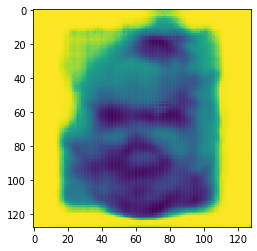

In [32]:
plt.imshow(g_items['masks'][2][0,:,:,0])

In [ ]:
img_idx = 6
show_images([testAx,testBy,g_items['By_warpped'].numpy(),
             g_items['masks'][2][:,:,:,0],
             g_items['raw_fake_Ay'].numpy(),g_items['fake_Ay'].numpy(),
             g_items['fakeAy_to_Ax'],g_items['fakeBx_to_By'],g_items['fake_Bx']],1)

In [ ]:
for i in range(3):
  print(g_items['fakeAy_to_Ax'][0,:,:,i].numpy().mean())

In [ ]:
fig = plt.figure(figsize=(75, 75))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1],
        wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
img_idx = 6
imgs = [testAx[img_idx],testBy[img_idx],g_items['fakeBx_to_By'][img_idx],g_items['masks'][1][img_idx,:,:,0]]
for idx,img in enumerate(imgs):
    ax = plt.subplot(gs[0,idx])
    ax.axis('off')
    ax.imshow(np.clip((img+1)/2,0,1))

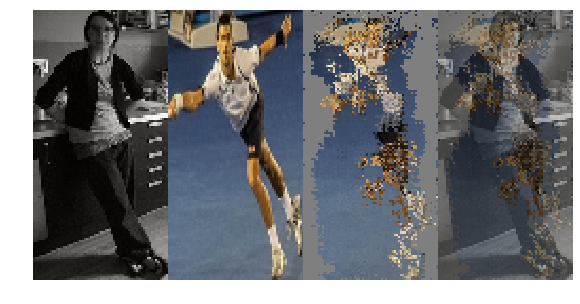

In [26]:
fig = plt.figure(figsize=(75, 75))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1],
        wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
img_idx = 7
imgs = [testAx[img_idx],testBy[img_idx],test_By_warpped[img_idx],test_raw_Ay[img_idx]]
for idx,img in enumerate(imgs):
    ax = plt.subplot(gs[0,idx])
    ax.axis('off')
    ax.imshow(np.clip((img+1)/2,0,1))

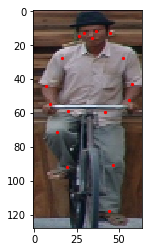

In [39]:
test_target_flow = (testByMark[img_idx]-testAxMark[img_idx])
draw_landmark_face(testAx[img_idx],testAxMark[img_idx])

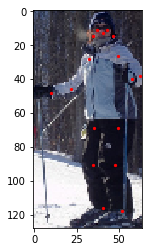

In [40]:
draw_landmark_face(testBy[img_idx],testByMark[img_idx])

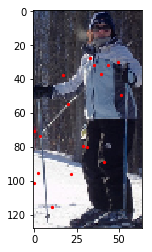

In [41]:
draw_landmark_face(testBy[img_idx],-test_sampled_flow[img_idx][0]+tf.cast(testByMark[0],'float'))

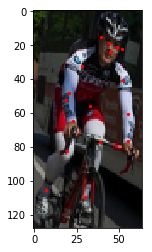

In [30]:
test_target_flow = (testByMark[img_idx]-testAxMark[img_idx])
draw_landmark_face(testAx[img_idx],testAxMark[img_idx])

In [ ]:
draw_landmark_face(testBy[img_idx],testByMark[img_idx])

In [ ]:
draw_landmark_face(testAx[img_idx],-test_sampled_flow[img_idx][0]+tf.cast(testByMark[0],'float'))

In [ ]:
draw_landmark_face(testAx[img_idx],testAxMark[img_idx])

In [ ]:
test_target_flow = (testByMark[img_idx]-testAxMark[img_idx])

In [ ]:
fig = plt.figure(figsize=(75, 75))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1],
        wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
img_idx = 9
imgs = [testAx[img_idx],testBy[img_idx],test_By_warpped[img_idx],test_raw_Ay[img_idx]]
for idx,img in enumerate(imgs):
    ax = plt.subplot(gs[0,idx])
    ax.imshow(np.clip((img+1)/2,0,1))
plt.savefig('test_img.png')

In [ ]:
draw_landmark_face(testBy[img_idx],testByMark[img_idx])

In [ ]:
draw_landmark_face(testAx[img_idx],-test_sampled_flow[img_idx][0]+tf.cast(testByMark[0],'float'))

In [ ]:
def save_images(Ax,By,Ay,epoch,batch_size):
    fig = plt.figure(figsize=(75, 75)) 
    gs = matplotlib.gridspec.GridSpec(batch_size, 3, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
    Ax = np.clip(Ax+1,0,1)
    By = np.clip(By+1,0,1)
    Ay = np.clip(Ay.numpy()+1,0,1)
    for i in range(batch_size):
        ax1=plt.subplot(gs[i,0])
        ax1.axis('off')
        ax2=plt.subplot(gs[i,1])
        ax2.axis('off')
        ax3=plt.subplot(gs[i,2])
        ax3.axis('off')
        ax1.imshow(Ax[i])
        ax2.imshow(By[i])
        ax3.imshow(Ay[i])
    plt.savefig('image4_at_epoch_{}.png'.format(epoch))

In [ ]:
for epoch in range(101,1000+1):
    print("epoch: {}".format(epoch))
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_flowNet_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    with train_summary_writer.as_default():
        for (idx, itemname) in enumerate(lossnames):
            tf.summary.scalar(itemname, metrics_list[idx].result(), step=epoch)
            metrics_list[idx].reset_states()
    if epoch % 10 == 0:
        for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
            g_items = generator(one_Ax,one_By,tf.cast(epoch,'float32'),False)
            save_images(one_Ax,one_By,g_items['fake_Ay'],epoch,BATCH_SIZE)
            break